In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
png_img = cv2.imread("data2/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
print("PNG shape:", png_img.shape, "dtype:", png_img.dtype)



PNG shape: (4096, 850, 3) dtype: uint8


In [102]:
H, W = 4096, 850
intensity = np.fromfile("data2/Horizontal/Intensity.bin", dtype=np.float64)
print("intensity size:", intensity.size, intensity.dtype, intensity.min(), intensity.max())
intensity= intensity[:H*W].reshape(W, H).T
print("Raw intensity size:", intensity.size)
print('shape:', intensity.shape, 'dtype:', intensity.dtype,
      'min:', intensity.min(), 'max:', intensity.max())

# intensity = (intensity - np.min(intensity)) / (np.max(intensity) - np.min(intensity))

intensity size: 3481601 float64 8.6916947602137e-311 133.1475326534781
Raw intensity size: 3481600
shape: (4096, 850) dtype: float64 min: 8.6916947602137e-311 max: 133.1475326534781


In [432]:
segmentation = np.fromfile("data2/Horizontal/Segmentation.bin", dtype=np.uint8)
# segmentation = np.fromfile("data2/Vertical/Segmentation.bin", dtype=np.uint8)
print("Segmentation size:", segmentation.size, segmentation.dtype,
      "min:", segmentation.min(), "max:", segmentation.max())
segmentation= segmentation[:H*W].reshape(W, H).T
print("Segmentation shape:", segmentation.shape, "dtype:", segmentation.dtype,
      "unique classes:", np.unique(segmentation))

Segmentation size: 3481608 uint8 min: 0 max: 255
Segmentation shape: (4096, 850) dtype: uint8 unique classes: [  0   3  16  82 255]


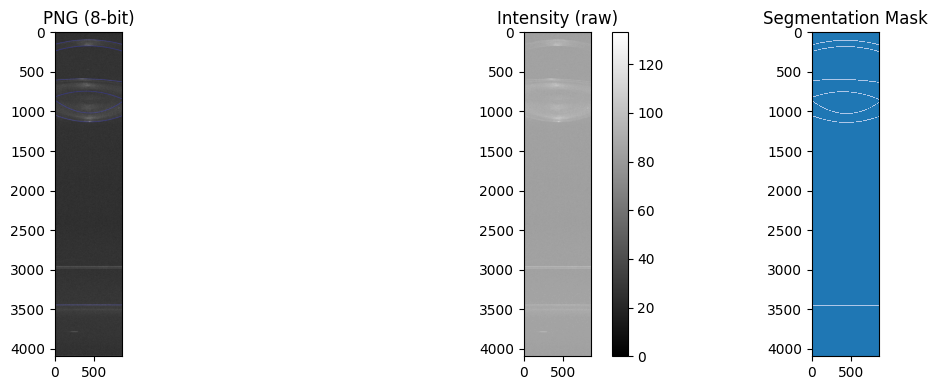

In [433]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("PNG (8-bit)")
plt.imshow(png_img)
# plt.axis("off")

plt.subplot(1,3,2)
plt.title("Intensity (raw)")
plt.imshow(intensity, cmap="gray")
plt.colorbar()
# plt.axis("off")

plt.subplot(1,3,3)
plt.title("Segmentation Mask")
plt.imshow(segmentation, cmap="tab20")  # colorful labels
# plt.axis("off")

plt.tight_layout()
plt.show()

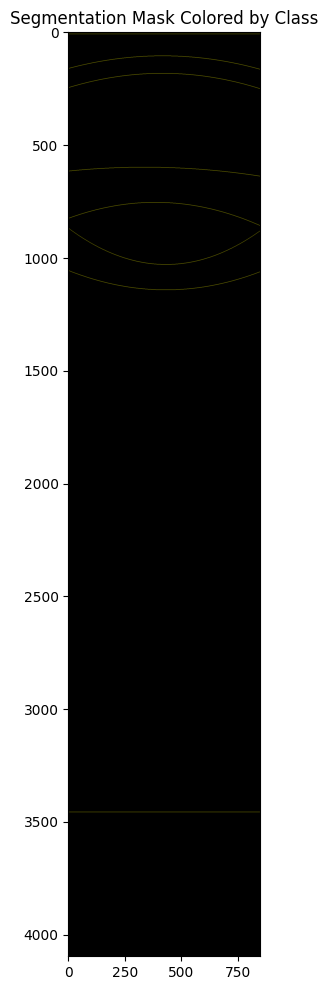

In [434]:
class_colors = {
    0: (0, 0, 0),       # black = background
    3: (255, 0, 0),     # red
    16: (0, 255, 0),    # green
    82: (0, 0, 255),    # blue
    255: (255, 255, 0)}  # yellow
seg= segmentation
seg_rgb = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for cls_id, color in class_colors.items():
    seg_rgb[seg == cls_id] = color

# Display
plt.figure(figsize=(8, 12))
plt.imshow(seg_rgb)
# plt.axis("off")
plt.title("Segmentation Mask Colored by Class")
plt.show()

In [435]:
for cls in np.unique(seg):
    count = np.sum(seg == cls)
    percent = count / seg.size * 100
    print(f"Class {cls}: {count} pixels ({percent:.2f}%)")
np.unique(seg, return_counts=True)

Class 0: 3474797 pixels (99.80%)
Class 3: 1 pixels (0.00%)
Class 16: 1 pixels (0.00%)
Class 82: 1 pixels (0.00%)
Class 255: 6800 pixels (0.20%)


(array([  0,   3,  16,  82, 255], dtype=uint8),
 array([3474797,       1,       1,       1,    6800], dtype=int64))

In [436]:
import numpy as np
import matplotlib.pyplot as plt

# Binary mask for class 255
mask_255 = (seg == 255).astype(np.uint8)
print("Mask 255 dtype:", mask_255.dtype)
print("Mask 255 shape:", mask_255.shape, "Total pixels:", mask_255.sum())
w, h = mask_255.shape
print("Width, Height:", w, h)

Mask 255 dtype: uint8
Mask 255 shape: (4096, 850) Total pixels: 6800
Width, Height: 4096 850


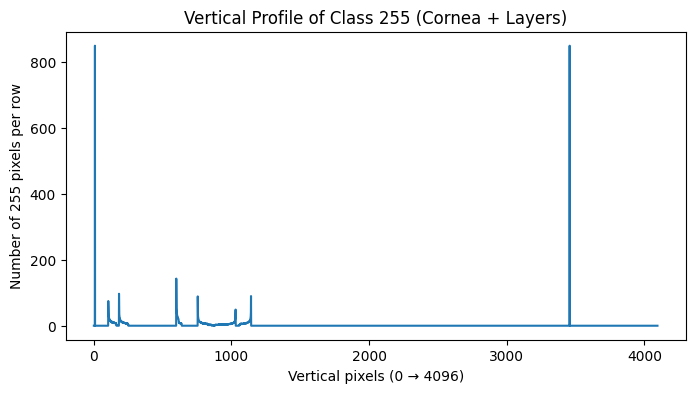

In [437]:
# Sum along width to get the vertical intensity profile
vertical_profile = mask_255.sum(axis=1)  # shape: (4096,)
plt.figure(figsize=(8,4))
plt.plot(vertical_profile)
plt.title("Vertical Profile of Class 255 (Cornea + Layers)")
plt.xlabel("Vertical pixels (0 → 4096)")
plt.ylabel("Number of 255 pixels per row")
plt.show()


In [438]:
# Find rows where 255 exists
rows_with_255 = np.where(vertical_profile > 0)[0]

# Detect continuous segments
segments = []
start = rows_with_255[0]
for i in range(1, len(rows_with_255)):
    if rows_with_255[i] != rows_with_255[i-1] + 1:
        end = rows_with_255[i-1]
        segments.append((start, end))
        start = rows_with_255[i]
segments.append((start, rows_with_255[-1]))

print("Detected 255 segments (row ranges):")
for i, (s,e) in enumerate(segments):
    print(f"Segment {i+1}: rows {s} → {e}")


Detected 255 segments (row ranges):
Segment 1: rows 8 → 8
Segment 2: rows 105 → 164
Segment 3: rows 183 → 250
Segment 4: rows 599 → 638
Segment 5: rows 755 → 857
Segment 6: rows 868 → 1030
Segment 7: rows 1056 → 1142
Segment 8: rows 3457 → 3457


In [372]:
segments[7][1]+1

3458

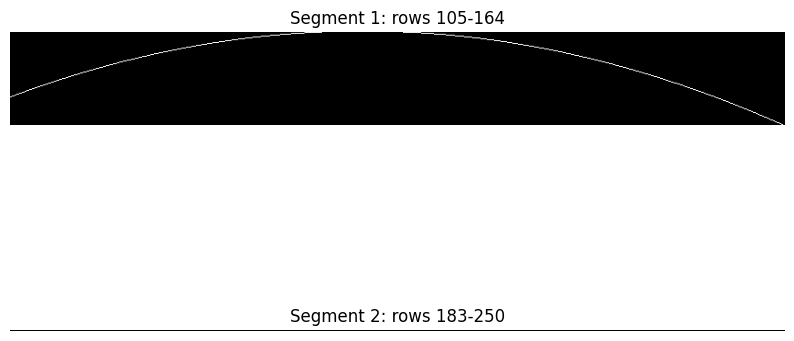

In [369]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.imshow(mask_255[755: 857, :], cmap="gray")
plt.title("Segment 1: rows 105-164")
plt.axis("off")

plt.subplot(2,1,2)
plt.imshow(mask_255[3457: 3458, :], cmap="gray")
plt.title("Segment 2: rows 183-250")
plt.axis("off")

# plt.tight_layout()
plt.show()


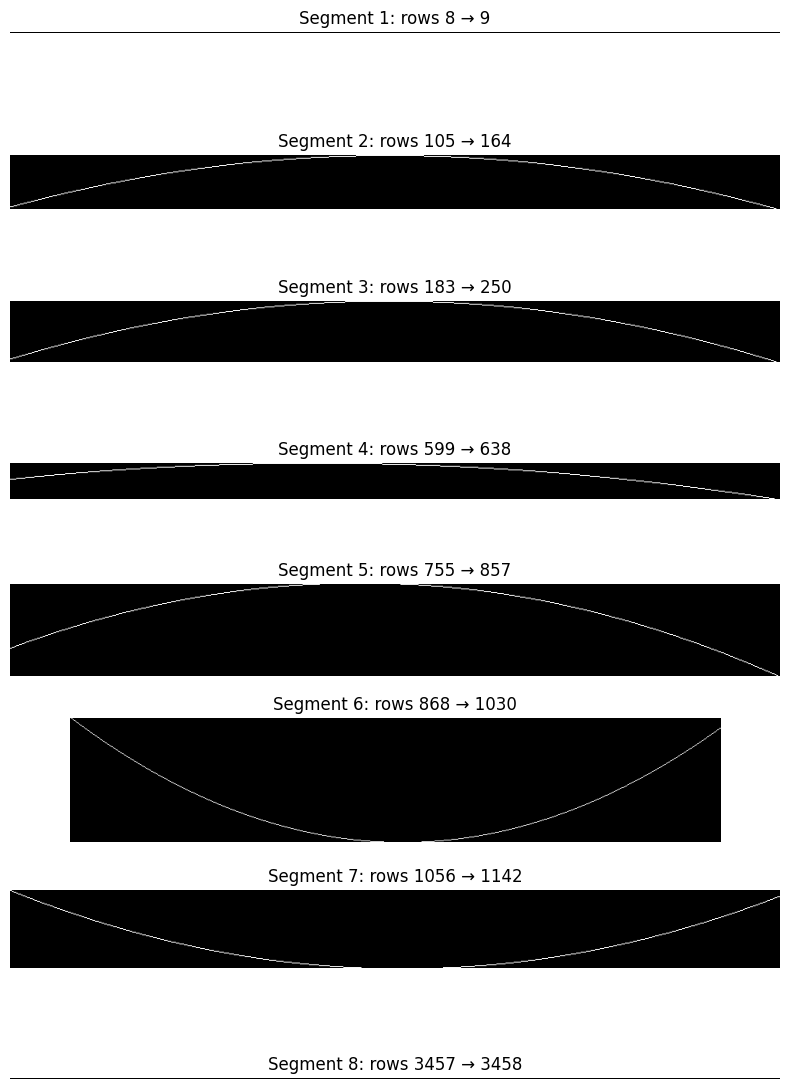

In [324]:
plt.figure(figsize=(8,12))
for i, (s,e) in enumerate(segments):
    plt.subplot(len(segments),1,i+1)
    if s ==e:
        e=e+1
    plt.imshow(mask_255[s:e,:], cmap="gray")
    plt.title(f"Segment {i+1}: rows {s} → {e}")
    plt.axis("off")
plt.tight_layout()
plt.show()


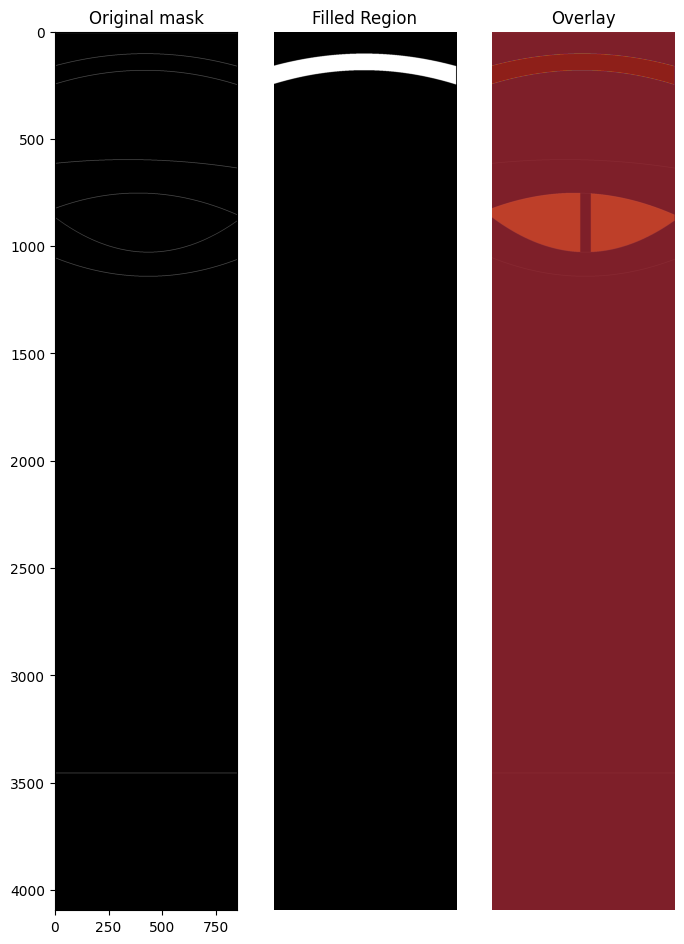

In [395]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fill_between_segments(mask, seg1_rows, seg2_rows):
    """
    Fill area between two curved segments.
    
    mask: binary mask (H x W) with 255 on segment lines
    seg1_rows: (start_row, end_row) for first segment
    seg2_rows: (start_row, end_row) for second segment
    
    returns: binary mask with filled region
    """
    H, W = mask.shape
    filled_mask = np.zeros_like(mask, dtype=np.uint8)

    for col in range(W):
        # Find where segment 1 and segment 2 have 255 in this column
        seg1_points = np.where(mask[seg1_rows[0]:seg1_rows[1], col] == 255)[0]
        seg2_points = np.where(mask[seg2_rows[0]:seg2_rows[1], col] == 255)[0]

        if len(seg1_points) > 0 and len(seg2_points) > 0:
            top = seg1_points[0] + seg1_rows[0]   # absolute row index
            bottom = seg2_points[-1] + seg2_rows[0]  # absolute row index

            # Fill between the two curves in this column
            filled_mask[top:bottom, col] = 255

    return filled_mask


# Example usage 
# Suppose mask_255 is your binary mask
# seg1 = (105, 164)   # rows for first segment
#     "Cornea":   (segments[1][0], segments[2][1]),
#     "Lens":     (segments[3][0], segments[6][1]),
#     "Nucleus":  (segments[4][0], segments[5][1]),
#     "Retina":   (segments[7][0], segments[7][1]),
seg1 = (105, 164)   # rows for first segment
seg2 = (183, 250)   # rows for second segment
seg3 = (599, 638)  
seg4 = (755, 857)
seg5 = (868, 1030)
seg6 = (1056, 1142)
seg7 = (3457, 3458)   # rows for second segment
filled = fill_between_segments(seg, seg1, seg2)
lense = fill_between_segments(seg, seg3, seg6)
nucleus = fill_between_segments(seg, seg4, seg5)
retina = fill_between_segments(seg, seg7, seg7)

# Plot
plt.figure(figsize=(8,12))
plt.subplot(1,3,1)
plt.title("Original mask")
plt.imshow(mask_255, cmap="gray")
# plt.imshow(filled, cmap="gray", alpha=0.5)

plt.subplot(1,3,2)
plt.title("Filled Region")
plt.imshow(filled, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(mask_255, cmap="gray")
plt.imshow(filled, cmap="jet", alpha=0.5)
# plt.imshow(lense, cmap="spring", alpha=0.5)
plt.imshow(nucleus, cmap="summer", alpha=0.5)
plt.imshow(retina, cmap="autumn", alpha=0.5)
plt.axis("off")
plt.show()


In [325]:
print(mask_255.shape, filled.shape)

(4096, 850) (4096, 850)


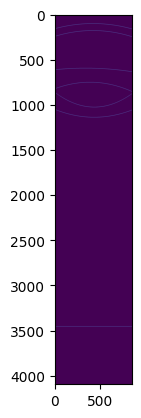

In [335]:
plt.imshow(seg)

In [399]:
pixels = []
no_pixels = []
for col in range(850):
    col_seg = seg[3455:3459, col]
    white_pixel = np.where(col_seg == 255)[0]
    # print(col, white_pixel)
    if len(white_pixel) >= 2:
        pixels.append(col)
    else:
        no_pixels.append(col)

print("Columns with >=2 white pixels:", len(pixels), pixels)
if no_pixels:
    print("Columns with <2 white pixels:", len(no_pixels), no_pixels)
    # if np.any(col_seg >= 205):
    #     print(col, "pixel", np.where(col_seg == 255)[0] + 50)
        
      

Columns with >=2 white pixels: 0 []
Columns with <2 white pixels: 850 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,

h 850
Polygon shape: (1700, 2) dtype: [[  0 826]
 [  1 826]
 [  2 825]
 [  3 825]
 [  4 825]
 [  5 824]
 [  6 824]
 [  7 823]
 [  8 823]
 [  9 823]]
Mask2 shape: (4096, 850) dtype: uint8
Mask2 shape: (4096, 850) dtype: uint8


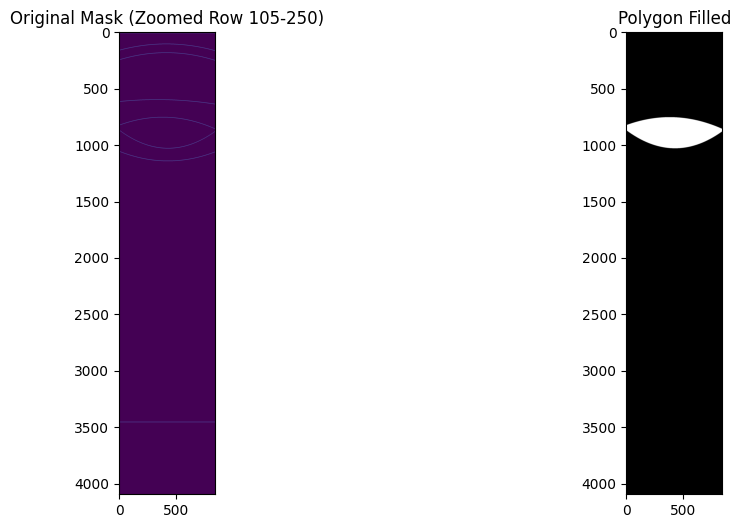

In [414]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

row_start, row_end = segments[4][0], segments[5][1] # Lense segments[7][0], segments[7][1] segments[4][0], segments[5][1]

h = mask_255.shape[1]
print("h", h)
top_curve = []
bottom_curve = []

# Scan each column
for col in range(h):
    col_segment = seg[row_start:row_end+1, col]
    # print("\nColumn", col, "segment sum:", col_segment)
    rows = np.where(col_segment == 255)[0]
    # print("  \nRows with 255:", rows)
    
    if len(rows) >= 1:  # must have both top and bottom
        top_curve.append((col, row_start + rows[0]))
        bottom_curve.append((col, row_start + rows[-1]))

# Combine into polygon (top + reversed bottom)
polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
print("Polygon shape:", polygon.shape, "dtype:", polygon[:10])
# Make filled polygon mask
poly_mask = np.zeros_like(mask_255)
poly_mask = np.ascontiguousarray(poly_mask)
if polygon.shape[0] > 0:
    cv2.fillPoly(poly_mask, [polygon], 255)
else:
    print("Warning: Polygon is empty, skipping fillPoly.")

mask2 = cv2.bitwise_and(mask_255, poly_mask)
print("Mask2 shape:", mask2.shape, "dtype:", mask2.dtype)
# cv2.fillPoly(mask3, [polygon], 255)
print("Mask2 shape:", mask2.shape, "dtype:", mask2.dtype)

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Mask (Zoomed Row 105-250)")
plt.imshow(mask_255)
# plt.imshow(mask3, alpha=0.5)

plt.subplot(1,2,2)
plt.title("Polygon Filled")
plt.imshow(poly_mask, cmap="gray")
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define regions of interest from segments
regions = {
    "Cornea":   (segments[1][0], segments[2][1]),
    "Lens":     (segments[3][0], segments[6][1]),
    "Nucleus":  (segments[4][0], segments[5][1]),
    "Retina":   (segments[7][0], segments[7][1]),
}

h = seg.shape[1]  # number of columns
polygons = {}          # store polygons
poly_masks = {}        # store filled polygon masks

for name, (row_start, row_end) in regions.items():
    top_curve = []
    bottom_curve = []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]

        if len(rows) >= 2:  # must have both top and bottom
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    # Combine into polygon
    polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
    polygons[name] = polygon

    # Make filled polygon mask
    poly_mask = np.zeros_like(mask_255)
    poly_mask = np.ascontiguousarray(poly_mask)
    if polygon.shape[0] > 0:
        cv2.fillPoly(poly_mask, [polygon], 255)
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

    poly_masks[name] = poly_mask

# --- Plot results ---
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.title("Original Mask")
plt.imshow(mask_255)

for i, (name, mask) in enumerate(poly_masks.items(), start=2):
    plt.subplot(2, 3, i)
    plt.title(name)
    plt.imshow(mask, cmap="gray")

plt.tight_layout()
plt.show()


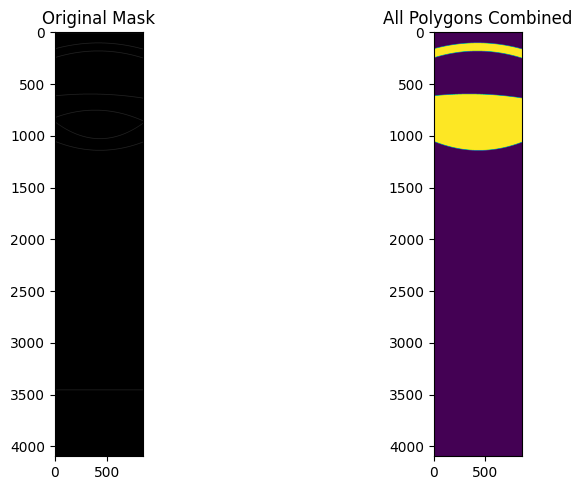

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define regions of interest from segments
regions = {
    "Cornea":   (segments[1][0], segments[2][1]),
    "Lens":     (segments[3][0], segments[6][1]),
    "Nucleus":  (segments[4][0], segments[5][1]),
    "Retina":   (segments[7][0], segments[7][1]),
}

h = seg.shape[1]  # number of columns
polygons = {}          # store polygons
poly_masks = {}        # store filled polygon masks

# one combined mask for all polygons
all_polygons_mask = np.zeros_like(mask_255)
all_polygons_mask = np.ascontiguousarray(all_polygons_mask)

for name, (row_start, row_end) in regions.items():
    top_curve = []
    bottom_curve = []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]

        if len(rows) >= 1:  # must have both top and bottom
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    # Combine into polygon
    polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
    polygons[name] = polygon

    # Make filled polygon mask
    poly_mask = np.zeros_like(mask_255)
    poly_mask = np.ascontiguousarray(poly_mask)
    if polygon.shape[0] > 0:
        cv2.fillPoly(poly_mask, [polygon], 255)
        cv2.fillPoly(all_polygons_mask, [polygon], 255)  # add to combined mask
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

    poly_masks[name] = poly_mask

# --- Plot results ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(seg, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("All Polygons Combined")
plt.imshow(mask_255, cmap="gray")           # show original in background
plt.imshow(all_polygons_mask)  # overlay polygons in color

plt.tight_layout()
plt.show()


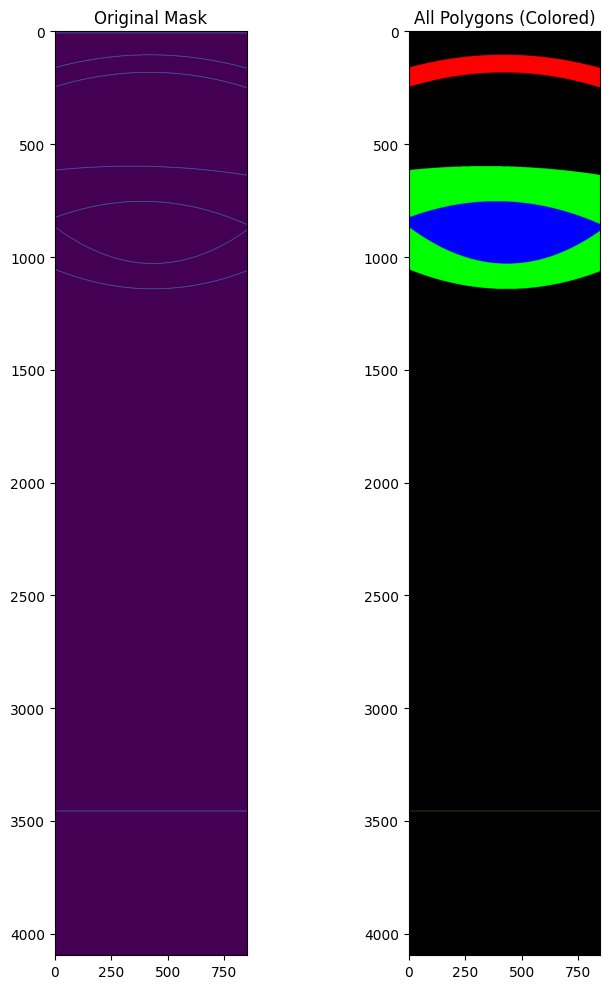

In [431]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define regions of interest from segments
regions = {
    "Cornea":   (segments[1][0], segments[2][1]),
    "Lens":     (segments[3][0], segments[6][1]),
    "Nucleus":  (segments[4][0], segments[5][1]),
    "Retina":   (segments[7][0]-1, segments[7][1]+1),
}

h = seg.shape[1]  # number of columns
polygons = {}     # store polygons

for name, (row_start, row_end) in regions.items():
    top_curve = []
    bottom_curve = []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]

        if len(rows) >= 1:  # must have both top and bottom
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    # Combine into polygon
    polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
    polygons[name] = polygon

# --- Create one combined colored mask ---
colored_mask = np.zeros((*mask_255.shape, 3), dtype=np.uint8)

# Assign unique colors (BGR format for cv2)
colors = {
    "Cornea":  (255, 0, 0),     # Blue
    "Lens":    (0, 255, 0),     # Green
    "Nucleus": (0, 0, 255),     # Red
    "Retina":  (255, 255, 0),   # Cyan
}

for name, polygon in polygons.items():
    if polygon.shape[0] > 0:
        cv2.fillPoly(colored_mask, [polygon], colors[name])
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

# --- Plot results ---
plt.figure(figsize=(8, 10))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(mask_255)

plt.subplot(1, 2, 2)
plt.title("All Polygons (Colored)")
plt.imshow(colored_mask)

plt.tight_layout()
plt.show()


⚠️ Warning: Retina polygon empty, skipped.


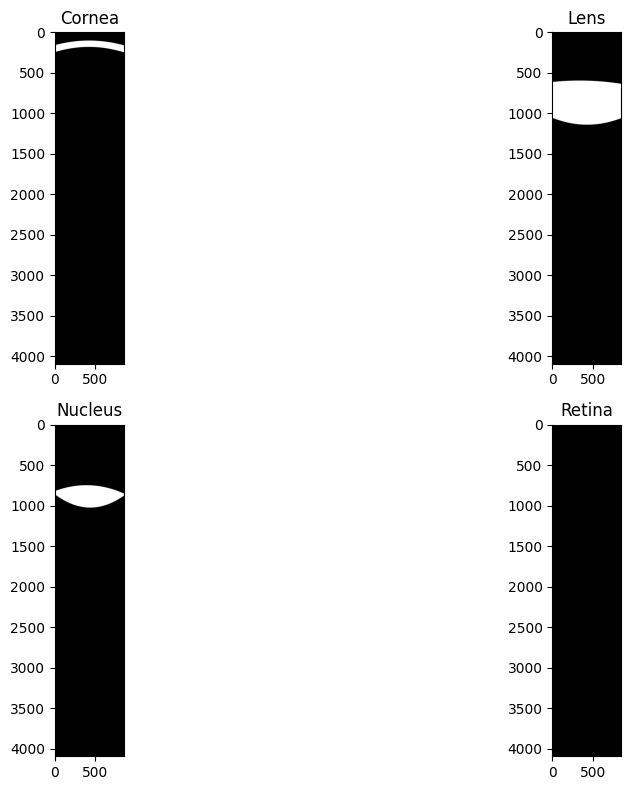

In [366]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- Segment definitions (row ranges) ---
segment_defs = {
    "Cornea":   (segments[1][0], segments[2][1]),
    "Lens":     (segments[3][0], segments[6][1]),
    "Nucleus":  (segments[4][0], segments[5][1]),
    "Retina":   (segments[7][0]-2, segments[7][1]+2),
}

h = seg.shape[1]   # image width (columns)

# Dictionary to store results
polygons = {}
poly_masks = {}

for name, (row_start, row_end) in segment_defs.items():
    top_curve = []
    bottom_curve = []

    # Scan each column for segment rows
    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]

        if len(rows) >= 2:  # must have both top & bottom edges
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    # Build polygon
    polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
    polygons[name] = polygon

    # Create mask for this polygon
    poly_mask = np.zeros_like(mask_255)
    poly_mask = np.ascontiguousarray(poly_mask)
    if polygon.shape[0] > 0:
        cv2.fillPoly(poly_mask, [polygon], 255)
    else:
        print(f"⚠️ Warning: {name} polygon empty, skipped.")
    poly_masks[name] = poly_mask

# --- Plot results ---
plt.figure(figsize=(14, 8))

for i, (name, poly_mask) in enumerate(poly_masks.items(), 1):
    plt.subplot(2, 2, i)
    plt.title(name)
    plt.imshow(poly_mask, cmap="gray")

plt.tight_layout()
plt.show()


In [330]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Example mask (replace this with your real binary mask)
# shape: (4096, 850)
# mask = np.zeros((4096, 850), dtype=np.uint8)
mask = mask_255
# Just for testing: draw two curved lines
# for x in range(850):
#     mask[105 + int(20*np.sin(x/50)), x] = 255
#     mask[250 - int(20*np.cos(x/50)), x] = 255

# Parameters
row_start, row_end = 105, 250
h = mask.shape[1]

top_curve = []
bottom_curve = []

# Scan each column
for col in range(h):
    col_segment = mask[row_start:row_end+1, col]  # extract vertical slice
    rows = np.where(col_segment == 255)[0]
    if len(rows) >= 2:
        top_curve.append((col, row_start + rows[0]))
        bottom_curve.append((col, row_start + rows[-1]))

# Build polygon (top + reversed bottom)
polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)

# Draw polygon on a copy of mask
poly_mask = np.zeros_like(mask)
poly_mask = np.ascontiguousarray(poly_mask)
cv2.fillPoly(poly_mask, [polygon], 255)

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Mask")
plt.imshow(mask[row_start:row_end+1,:], cmap="gray")

plt.subplot(1,2,2)
plt.title("Polygon Filled")
plt.imshow(poly_mask[row_start:row_end+1,:], cmap="gray")
plt.show()


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2426: error: (-215:Assertion failed) p.checkVector(2, CV_32S) > 0 in function 'cv::fillPoly'


In [234]:
map = {
    "Cornea": segments[1:2],   # combine first 2 segments
    "Lens": segments[3:6],     # next 4 segments
    "Nucleus": segments[4:5],  # overlapping segment indices
    "Retina": [segments[7]]    # last relevant segment
}

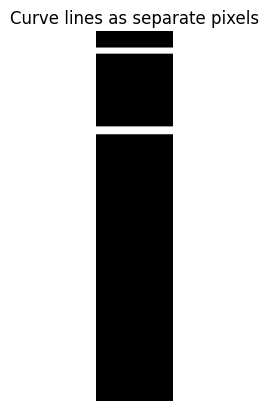

In [331]:
import numpy as np
import matplotlib.pyplot as plt

# segment row ranges
seg1 = segments[2]  # (128, 195)
seg2 = segments[6]  # (204, 281)

H, W = mask_255.shape

# create empty mask
area_mask = np.zeros((H, W), dtype=np.uint8)

# mark pixels for each segment as 1
area_mask[seg1[0]:seg1[1]+1, :] = 1
area_mask[seg2[0]:seg2[1]+1, :] = 1

plt.imshow(area_mask, cmap="gray")
plt.title("Curve lines as separate pixels")
plt.axis("off")
plt.show()


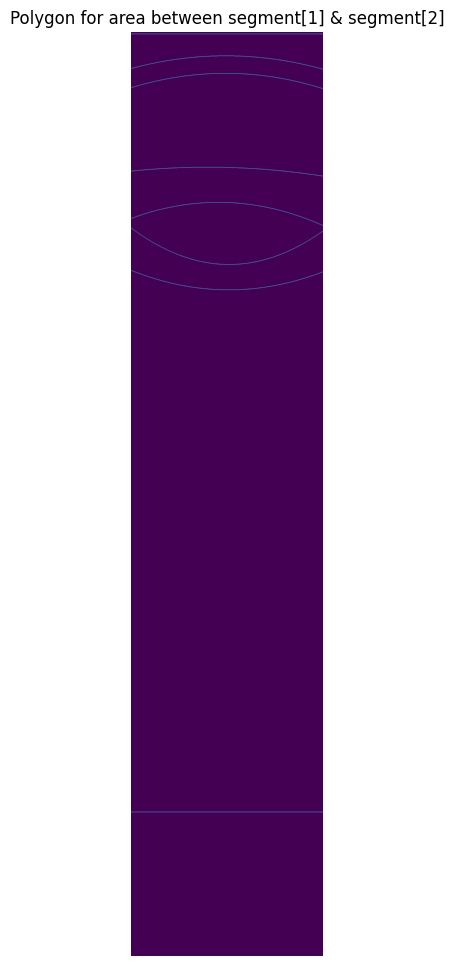

In [236]:
import cv2

mask_uint8 = (area_mask * 255).astype(np.uint8)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(8,12))
plt.imshow(mask_255)
# for cnt in contours:
#     plt.plot(cnt[:,0,0], cnt[:,0,1], color="red", linewidth=1)
plt.title("Polygon for area between segment[1] & segment[2]")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
from scipy.ndimage import label
import os

def load_and_extract_segments(file_path, shape=None):
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} not found")
    
    # Load binary file into NumPy array
    # If shape is provided, reshape the data; otherwise, assume it's a flat array
    data = np.fromfile(file_path, dtype=np.uint8)
    if shape is not None:
        data = data[-shape[0]*shape[1]:].reshape(shape)
    
    # Ensure the data is binary (0 and 255)
    if not np.all(np.isin(data, [0, 255])):
        print("Warning: Data contains values other than 0 and 255")
    
    # Create a binary mask (True for 255, False for 0)
    binary_mask = (data == 255)
    
    # Label connected components
    labeled_array, num_segments = label(binary_mask)
    
    # Extract segment information
    segments2 = []
    for i in range(1, num_segments + 1):
        # Get coordinates of pixels in the current segment
        segment_coords = np.where(labeled_array == i)
        segment = {
            'label': i,
            'coordinates': list(zip(segment_coords[0], segment_coords[1])),
            'size': len(segment_coords[0])  # Number of pixels in segment
        }
        segments2.append(segment)
    
    return segments2, labeled_array, data

# Example usage
file_path = "data2/Horizontal/Segmentation.bin"  # Replace with your file path
shape = (850, 4096)  # Replace with actual dimensions, e.g., (512, 512)

try:
    segments2, labeled_array, original_data = load_and_extract_segments(file_path, shape)
    
    # Print segment information
    print(f"Found {len(segments2)} segments:")
    for segment in segments2:
        print(f"Segment {segment['label']}:")
        print(f"  Size: {segment['size']} pixels")
        print(f"  Sample coordinates (first 5): {segment['coordinates'][:5]}")
    
    # Optional: Visualize the labeled segments (requires matplotlib)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Binary Image")
    plt.imshow(original_data, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Labeled Segments")
    plt.imshow(labeled_array, cmap='nipy_spectral')
    plt.show()

except Exception as e:
    print(f"Error: {e}")

Successfully created mask between segments
Mask shape: (4096, 850)
Polygon has 2 points


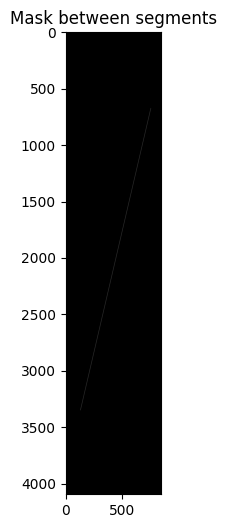

In [263]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

def create_mask_between_segments(bin_file_path, output_mask_path=None):
    """
    Create a mask between two curved segments in a binary segmentation file
    
    Args:
        bin_file_path: Path to the .bin file
        output_mask_path: Optional path to save the resulting mask
    
    Returns:
        mask: Binary mask between the two segments
        polygon: Coordinates of the polygon
    """
    
    # Read the binary file
    with open(bin_file_path, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
    
    # Reshape to 4096x850
    segmentation = data[:4096*850].reshape((4096, 850))
    
    # Create binary mask (255 becomes 1, everything else 0)
    binary_mask = (segmentation == 255).astype(np.uint8)
    
    # Label connected components
    labeled_mask, num_features = ndimage.label(binary_mask)
    
    if num_features < 2:
        raise ValueError("Need at least two segments, found {}".format(num_features))
    
    # Get the two largest segments (assuming they're the ones we want)
    sizes = []
    for i in range(1, num_features + 1):
        sizes.append(np.sum(labeled_mask == i))
    
    # Get indices of two largest segments
    largest_indices = np.argsort(sizes)[-2:]
    segment1 = (labeled_mask == largest_indices[0] + 1)
    segment2 = (labeled_mask == largest_indices[1] + 1)
    
    # Find boundaries for each segment
    def find_boundaries(segment_mask):
        """Find top and bottom boundaries for each column"""
        height, width = segment_mask.shape
        top_boundary = np.full(width, -1, dtype=int)
        bottom_boundary = np.full(width, -1, dtype=int)
        
        for col in range(width):
            column_data = segment_mask[:, col]
            if np.any(column_data):
                # Find first and last non-zero pixel in this column
                rows = np.where(column_data)[0]
                top_boundary[col] = rows[0]
                bottom_boundary[col] = rows[-1]
        
        return top_boundary, bottom_boundary
    
    # Get boundaries for both segments
    top1, bottom1 = find_boundaries(segment1)
    top2, bottom2 = find_boundaries(segment2)
    
    # Determine which segment is above/below
    # Compare average y-position to determine ordering
    avg_y1 = np.mean([y for y in top1 if y != -1] + [y for y in bottom1 if y != -1])
    avg_y2 = np.mean([y for y in top2 if y != -1] + [y for y in bottom2 if y != -1])
    
    if avg_y1 < avg_y2:
        upper_segment_top, upper_segment_bottom = top1, bottom1
        lower_segment_top, lower_segment_bottom = top2, bottom2
    else:
        upper_segment_top, upper_segment_bottom = top2, bottom2
        lower_segment_top, lower_segment_bottom = top1, bottom1
    
    # Create polygon points
    polygon_points = []
    
    # Add points from upper segment bottom boundary (left to right)
    for col in range(len(upper_segment_bottom)):
        if upper_segment_bottom[col] != -1:
            polygon_points.append([col, upper_segment_bottom[col]])
    
    # Add points from lower segment top boundary (right to left)
    for col in range(len(lower_segment_top) - 1, -1, -1):
        if lower_segment_top[col] != -1:
            polygon_points.append([col, lower_segment_top[col]])
    
    # Convert to numpy array
    polygon = np.array(polygon_points, dtype=np.int32)
    
    # Create mask from polygon
    mask = np.zeros_like(segmentation, dtype=np.uint8)
    cv2.fillPoly(mask, [polygon], 255)
    
    # Save if output path provided
    if output_mask_path:
        mask.astype(np.uint8).tofile(output_mask_path)
    
    return mask, polygon

# Usage example
if __name__ == "__main__":
    input_file = "data2/Horizontal/Segmentation.bin"
    output_file = "between_segments_mask.bin"
    
    try:
        mask, polygon = create_mask_between_segments(input_file, output_file)
        print(f"Successfully created mask between segments")
        print(f"Mask shape: {mask.shape}")
        print(f"Polygon has {len(polygon)} points")
        
        # Visualize (optional)
        plt.figure(figsize=(12, 6))
        plt.imshow(mask, cmap='gray')
        plt.title('Mask between segments')
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")